# Use GLPDepth and DPT

In [1]:
# conda install -c huggingface transformers

# First DPT

In [2]:
# 1. Import Module
import os, sys
import random
import itertools
import io
import math
import pandas as pd
import numpy as np
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2

from torchvision import datasets, transforms
from PIL import Image

# Depth estimation

In [3]:
# 변수 설졍
device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))

# Midas MOdel type 선택하기
model_type = 'DPT_Hybrid' # DPT_Large, MiDaS_small

midas = torch.hub.load('intel-isl/MiDaS', model_type)

midas.to(device) # GPU 등록
midas.eval() # 학습 No.

# transform 정의
midas_transforms = torch.hub.load('intel-isl/MiDaS','transforms') # MiDaS 내의 transforms 방식을 이용
if model_type == 'DPT_Large' or model_type == 'DPT_Hybrid':
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\Admin/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Admin/.cache\torch\hub\intel-isl_MiDaS_master


In [4]:
filename1 = './000008.png'
img = cv2.imread(filename1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # matplotlib과 opencv의 rgb 채녈의 순서가 다르기 때문에 고려.

In [5]:
img.shape

(375, 1242, 3)

In [6]:
input_batch = transform(img).to(device)

# 학습 No.
with torch.no_grad():
    pred = midas(input_batch)
    
    pred = torch.nn.functional.interpolate( # 작은 크기의 feature를 크게 만들 때 사용
            pred.unsqueeze(1), # batch dim
            size = img.shape[:2], # rgb channel threshold
            mode='bicubic', # bilinear interpolation 방법을 이용한 것으로 
                        # 이미지와 같은 height, width의 속성을 가지는 데이터에 적합한 interpolation 방법
            align_corners=True).squeeze() # dim-1 차원 버리기
output = pred.cpu().numpy() # cpu에 할당

C:\Users\Admin\anaconda3\envs\tensorflow2_py38\lib\site-packages\torch\nn\functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [7]:
output.shape

(375, 1242)

In [8]:
output

array([[1817.3474, 1811.7792, 1818.2185, ..., 1548.1903, 1548.12  ,
        1230.6974],
       [1774.251 , 1815.6375, 1819.2499, ..., 1543.9441, 1530.3973,
        1549.7983],
       [1823.3824, 1818.4186, 1815.817 , ..., 1543.3113, 1544.1302,
        1547.1315],
       ...,
       [3364.7297, 3367.2524, 3358.8591, ..., 2661.1836, 2652.255 ,
        2648.1929],
       [3372.4224, 3368.722 , 3370.7803, ..., 2651.1335, 2652.4797,
        2631.9036],
       [3358.8782, 3370.475 , 3367.6917, ..., 2649.3484, 2636.77  ,
        2616.042 ]], dtype=float32)

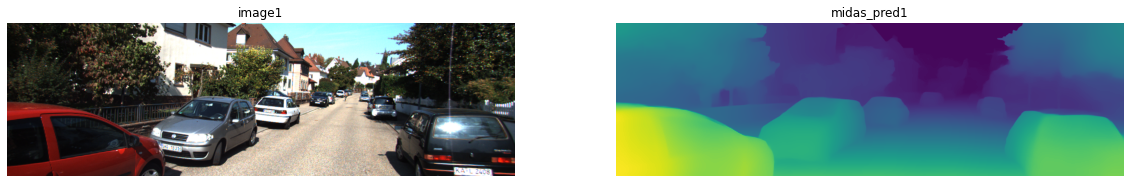

In [9]:
fig = plt.figure(figsize=(20,20))
k=1
for i in range(1,3):
    fig.add_subplot(1,2,i)
    
    if i % 2 == 0:
        plt.imshow(output)
        plt.title('midas_pred'+str(k))
        k += 1
        
    else:
        plt.imshow(img)
        plt.title('image'+str(k))
    plt.axis('off')

# Object Detection

In [10]:
# 2. Make COCO dataset
# COCO classes (91개)
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# 3. Preprocessing and bounding box
# standard PyTorch mean-std input image normalization
dpt_transform = transforms.Compose([
    #transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# 4. Detection
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    print(img.shape)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [11]:
detr_101 = torch.hub.load('facebookresearch/detr:main', 'detr_resnet101', pretrained=True) # Use resnet 101
detr_101.eval()

Using cache found in C:\Users\Admin/.cache\torch\hub\facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

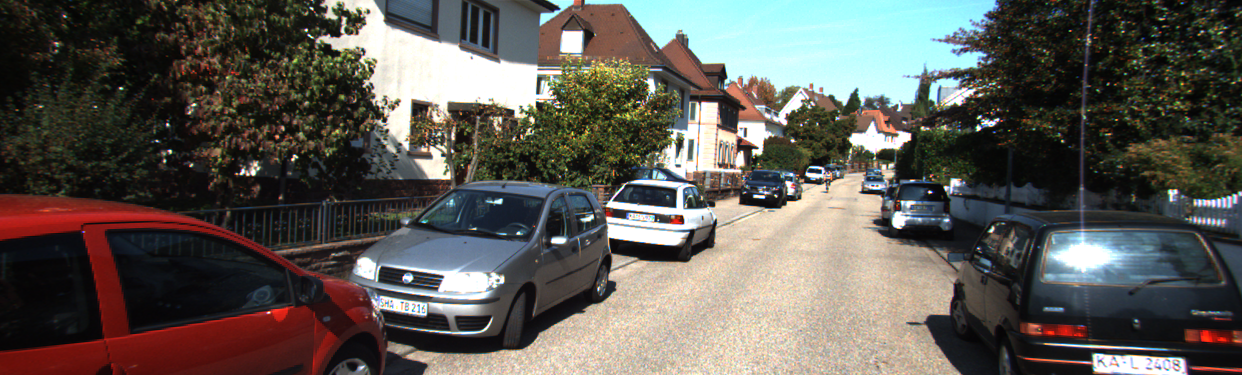

In [58]:
img = Image.open(filename1)
img

In [59]:
scores, boxes = detect(img, detr_101, dpt_transform)

torch.Size([1, 3, 375, 1242])


In [14]:
boxes # xmin, ymin, xmax, ymax

tensor([[7.7967e+02, 1.7029e+02, 8.0314e+02, 1.9988e+02],
        [7.7717e+02, 1.7049e+02, 7.9990e+02, 1.9972e+02],
        [8.8370e+02, 1.8072e+02, 9.5461e+02, 2.3529e+02],
        [3.4383e+02, 1.7912e+02, 6.2218e+02, 3.5221e+02],
        [8.8475e+02, 1.7322e+02, 9.0238e+02, 1.8766e+02],
        [9.4963e+02, 1.7766e+02, 9.7077e+02, 1.9642e+02],
        [8.8389e+02, 1.7836e+02, 9.5692e+02, 2.3633e+02],
        [7.3991e+02, 1.6798e+02, 7.9145e+02, 2.0761e+02],
        [8.3237e+02, 1.6358e+02, 8.4791e+02, 1.7722e+02],
        [8.0669e+02, 1.6601e+02, 8.3358e+02, 1.8480e+02],
        [6.0047e+02, 1.7832e+02, 7.1882e+02, 2.5836e+02],
        [8.2450e+02, 1.6631e+02, 8.4127e+02, 1.8006e+02],
        [9.4834e+02, 2.1253e+02, 1.2415e+03, 3.7124e+02],
        [8.3529e+02, 1.6659e+02, 8.5122e+02, 1.7990e+02],
        [7.8616e+02, 1.7040e+02, 8.0752e+02, 1.9826e+02],
        [9.8451e-01, 1.9408e+02, 3.9180e+02, 3.7094e+02],
        [6.2729e+02, 1.6466e+02, 6.9341e+02, 1.8188e+02],
        [8.631

In [15]:
scores

tensor([[3.3521e-10, 3.1751e-04, 9.1057e-06,  ..., 7.8253e-09, 3.4345e-09,
         6.9674e-10],
        [9.2916e-10, 3.0376e-03, 4.2966e-05,  ..., 5.5096e-08, 1.3261e-08,
         7.3347e-09],
        [9.0424e-11, 5.6511e-05, 1.4779e-06,  ..., 8.6368e-10, 4.0249e-09,
         9.0313e-11],
        ...,
        [1.2128e-11, 2.2562e-05, 1.6337e-07,  ..., 3.3091e-10, 1.0309e-10,
         2.0506e-12],
        [8.6783e-11, 5.4570e-04, 2.1128e-06,  ..., 1.7613e-08, 1.1336e-08,
         8.5743e-10],
        [3.9417e-10, 1.4133e-04, 8.7763e-06,  ..., 5.1000e-09, 5.6704e-09,
         5.8430e-10]], grad_fn=<IndexBackward>)

In [16]:
scores.shape

torch.Size([18, 91])

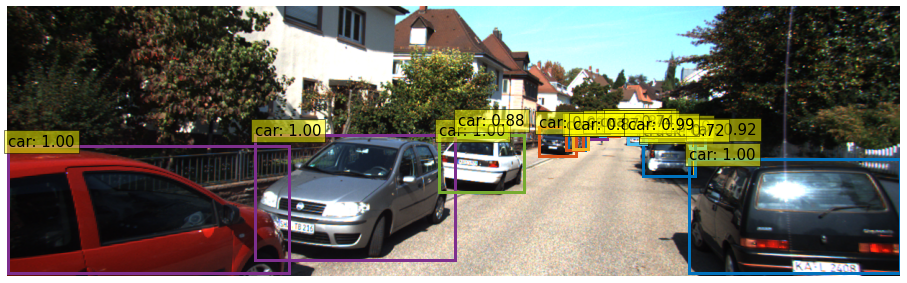

In [17]:
# 시각화 (특정 부분만)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores, boxes)

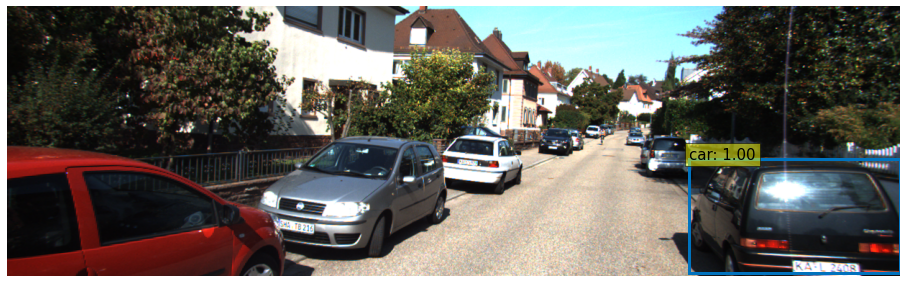

In [18]:
# 시각화 (특정 부분만)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores[12:13], boxes[12:13])

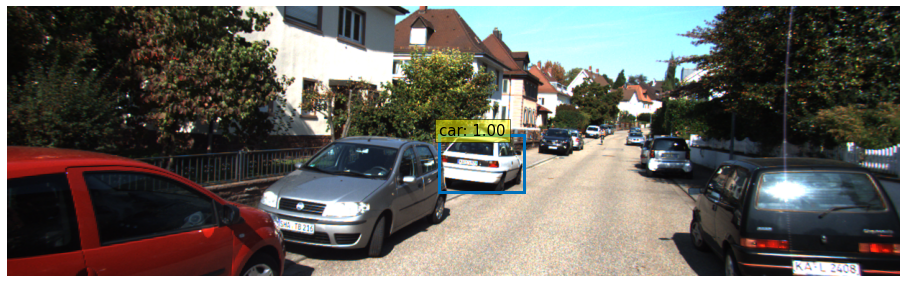

In [19]:
# 시각화 (특정 부분만)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores[10:11], boxes[10:11])

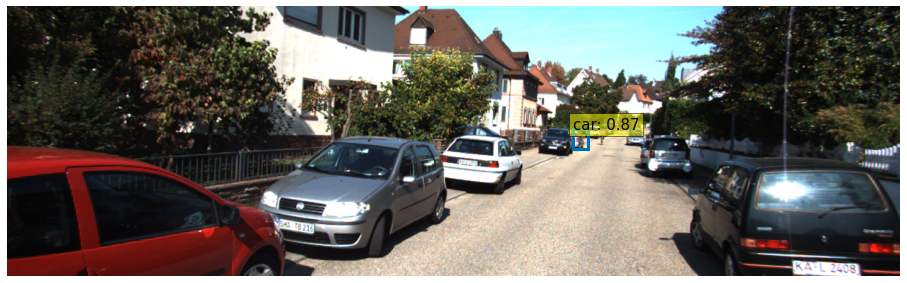

In [20]:
# 시각화 (특정 부분만)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores[14:15], boxes[14:15])

In [21]:
scores[12]

tensor([1.7015e-11, 2.3941e-05, 4.4030e-07, 9.9914e-01, 3.5532e-06, 3.5005e-08,
        8.0725e-06, 3.4997e-08, 1.4214e-04, 7.4928e-07, 1.8622e-07, 4.6773e-07,
        1.4001e-11, 1.5208e-06, 4.8837e-06, 1.3337e-06, 1.2839e-08, 7.7486e-08,
        4.8331e-07, 1.0388e-08, 1.9300e-06, 1.3238e-07, 3.5539e-09, 8.8109e-11,
        3.1752e-07, 8.0491e-10, 1.8620e-11, 1.8779e-07, 2.7899e-07, 9.2216e-12,
        1.9139e-11, 2.0306e-07, 6.6573e-11, 1.0186e-07, 2.4640e-07, 2.5528e-10,
        3.8732e-10, 3.7492e-07, 2.8734e-08, 4.0974e-11, 7.9624e-09, 1.5945e-08,
        4.5991e-10, 6.5518e-09, 7.7776e-10, 5.9218e-12, 4.9682e-09, 5.6881e-07,
        2.8227e-11, 3.2561e-12, 1.6545e-10, 1.0816e-06, 2.9580e-09, 6.0559e-07,
        5.1646e-09, 1.6847e-06, 2.3374e-09, 2.6917e-10, 2.9032e-10, 5.3625e-08,
        5.6401e-08, 4.4111e-11, 1.1479e-06, 4.5055e-06, 1.1756e-06, 7.2817e-09,
        1.1014e-11, 3.5594e-07, 1.3472e-11, 8.8378e-12, 5.9607e-08, 8.9950e-12,
        2.3677e-06, 1.8438e-08, 8.1049e-

In [22]:
boxes[12] # xmin, ymin, xmax, ymax 좌표

tensor([ 948.3389,  212.5329, 1241.5376,  371.2375], grad_fn=<SelectBackward>)

In [23]:
coordinate1 = boxes[12].round()
coordinate1

tensor([ 948.,  213., 1242.,  371.], grad_fn=<RoundBackward>)

In [24]:
coordinate2 = boxes[10].round()
coordinate2

tensor([600., 178., 719., 258.], grad_fn=<RoundBackward>)

In [25]:
coordinate3 = boxes[14].round()
coordinate3

tensor([786., 170., 808., 198.], grad_fn=<RoundBackward>)

# Depth image와 과연 얼마나 상관관계가 있을지 확인해보자

In [26]:
output

array([[1817.3474, 1811.7792, 1818.2185, ..., 1548.1903, 1548.12  ,
        1230.6974],
       [1774.251 , 1815.6375, 1819.2499, ..., 1543.9441, 1530.3973,
        1549.7983],
       [1823.3824, 1818.4186, 1815.817 , ..., 1543.3113, 1544.1302,
        1547.1315],
       ...,
       [3364.7297, 3367.2524, 3358.8591, ..., 2661.1836, 2652.255 ,
        2648.1929],
       [3372.4224, 3368.722 , 3370.7803, ..., 2651.1335, 2652.4797,
        2631.9036],
       [3358.8782, 3370.475 , 3367.6917, ..., 2649.3484, 2636.77  ,
        2616.042 ]], dtype=float32)

In [27]:
output.shape

(375, 1242)

In [28]:
output[213:372, 948:1243] 

array([[ 647.99023,  644.7046 ,  636.9327 , ...,  684.3798 ,  684.3298 ,
         682.0581 ],
       [ 649.8305 ,  646.3912 ,  639.5626 , ...,  685.8407 ,  685.74603,
         683.44403],
       [ 651.4856 ,  647.9436 ,  642.34174, ...,  687.3002 ,  687.0809 ,
         684.655  ],
       ...,
       [2159.8809 , 2159.2703 , 2158.666  , ..., 2653.7368 , 2653.0847 ,
        2651.7585 ],
       [2168.2703 , 2167.7715 , 2167.2222 , ..., 2652.9653 , 2650.329  ,
        2635.779  ],
       [2180.0845 , 2179.714  , 2179.2717 , ..., 2656.9983 , 2655.5022 ,
        2653.2324 ]], dtype=float32)

# DPT -  차가 멀어질 수록 depth map의 value average가 줄어든다.

In [29]:
# label 12
output[213:372, 948:1243].mean() # max

2072.7732

In [30]:
# label 10
output[178:259, 600:720].mean()

890.8785

In [31]:
# label 14
output[170:199, 786:809].mean()

279.95398

# GLPDepth 이용해보기 - Kitti(or NYU2) Pre-trained model.

In [34]:
# pip install git+https://github.com/huggingface/transformers

In [97]:
import transformers
print(transformers.__version__) 
from transformers import GLPNForDepthEstimation, GLPNFeatureExtractor

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-kitti") # glpn-nyu2
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti")

4.18.0.dev0


Downloading:   0%|          | 0.00/137 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/920 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

In [98]:
model.eval()

GLPNForDepthEstimation(
  (glpn): GLPNModel(
    (encoder): GLPNEncoder(
      (patch_embeddings): ModuleList(
        (0): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
      (block): ModuleList(

In [99]:
img = Image.open(filename1)
img_shape = (375, 1242, 3)

In [100]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 352, 1216])


In [101]:
with torch.no_grad():
    outputs = model(pixel_values) 
    predicted_depth = outputs.predicted_depth

In [102]:
predicted_depth.shape

torch.Size([1, 352, 1216])

In [103]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
                    predicted_depth.unsqueeze(1),
                    size=img_shape[:2],
                    mode="bicubic",
                    align_corners=False,
             )
prediction = prediction.squeeze().cpu().numpy()

In [104]:
prediction.shape

(375, 1242)

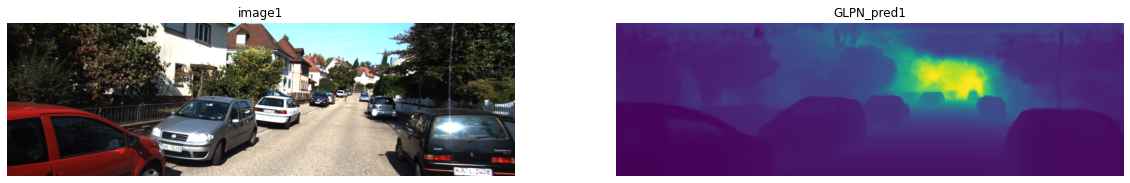

In [105]:
fig = plt.figure(figsize=(20,20))
k=1
for i in range(1,3):
    fig.add_subplot(1,2,i)
    
    if i % 2 == 0:
        plt.imshow(prediction)
        plt.title('GLPN_pred'+str(k))
        k += 1
        
    else:
        plt.imshow(img)
        plt.title('image'+str(k))
    plt.axis('off')

# GLPDepth는 멀어질 수록 value average가 커진다.

In [121]:
# label 12
prediction[213:372, 948:1243]

array([[2.4636629 , 2.4372895 , 2.4081154 , ..., 1.0540628 , 1.0548073 ,
        1.0451674 ],
       [2.4589136 , 2.436815  , 2.4007428 , ..., 1.0515426 , 1.0511268 ,
        1.0401161 ],
       [2.4546509 , 2.4384744 , 2.3925266 , ..., 1.04987   , 1.0486518 ,
        1.0368584 ],
       ...,
       [0.7944613 , 0.79453516, 0.7945581 , ..., 0.53674954, 0.5321956 ,
        0.51312804],
       [0.790905  , 0.790749  , 0.79055   , ..., 0.5303238 , 0.52390265,
        0.5024426 ],
       [0.78734416, 0.7869362 , 0.78646654, ..., 0.5223082 , 0.5133875 ,
        0.49164057]], dtype=float32)

In [114]:
# label 12
prediction[213:372, 948:1243].mean()

0.7364304

In [107]:
# label 10
prediction[178:259, 600:720].mean() 

1.904066

In [108]:
# label 14
prediction[170:199, 786:809].mean()

5.690113

# 실제 데이터셋 zloc와 비교하기

1. data_label => (xmax-xmin) & (ymax - ymin) & depth_average 이렇게 3개의 변수를 가지고 zloc를 예측하면 더욱 좋은 결과가 나오지 않을까?  
2. (xmax-xmin) & (ymax - ymin)으로 scatter plot을 그린 다음에 zloc를 category로 설정한 후 scatter위에 표시한 시각화?  
- 예상결과: xmax-xmin 과 ymax-ymin 이 커질수록 zloc가 낮은 구간을 가지는 label이 되는 모습  
3. depth_average와 zloc간의 scatter plot 시각화  
- 예상결과: (GLP모델에서) depth map의 average가 높아질 수록, zloc가 멀어지는 효과. (DPT는 반대로)  

In [109]:
label_12 = 6.15
label_10 = 14.44
label_14 = 33.2

In [122]:
# GLP depth 값
glp12 = prediction[213:372, 948:1243].mean()
glp10 = prediction[178:259, 600:720].mean() 
glp14 = prediction[170:199, 786:809].mean()

# DPT depth 값
dpt12 = output[213:372, 948:1243].mean()
dpt10 = output[178:259, 600:720].mean() 
dpt14 = output[170:199, 786:809].mean()

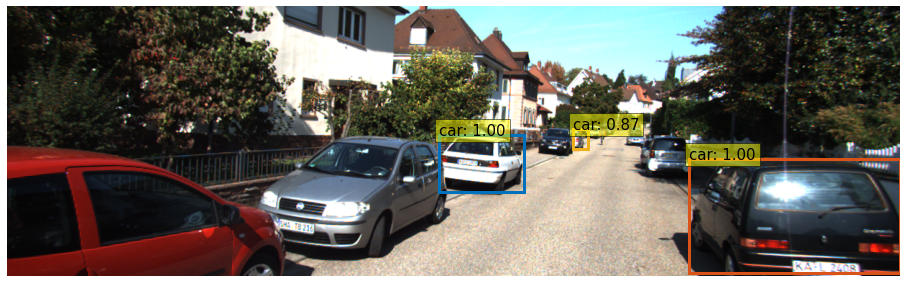

In [126]:
# 시각화 (앞 순서대로, 12, 10, 14)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores[[10,12,14]], boxes[[10,12,14]])

# 방법은 2가지
# Object Detection (DETR) (다른 것도 충분히 가능하다)
# GLPDepth, DPT, Midas (3개 정도) -> 가장 성능 좋은거, 비즈니스 모델 적합?
# RMSE (성능 지표)